# Exploratory Data Analysis notebook

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
dataset = pd.read_csv('../data/Clean_Dataset.csv')
dataset.shape

(300153, 12)

In [4]:
dataset.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


We can extract all categorical columns, and convert their type to dedicated to pandas dedicated 'category' type

In [21]:
categorical_columns = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

categorical_columns

for col in categorical_columns:
    dataset[col] = dataset[col].astype('category')

We dont really need Unnamed: 0, as it is a a index column, we can drop it. Lets also get the names of all categorical columns for future analysis

In [5]:
dataset.drop(columns=['Unnamed: 0'], inplace=True) 

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   flight            300153 non-null  category
 2   source_city       300153 non-null  category
 3   departure_time    300153 non-null  category
 4   stops             300153 non-null  category
 5   arrival_time      300153 non-null  category
 6   destination_city  300153 non-null  category
 7   class             300153 non-null  category
 8   duration          300153 non-null  float64 
 9   days_left         300153 non-null  int64   
 10  price             300153 non-null  int64   
dtypes: category(8), float64(1), int64(2)
memory usage: 9.5 MB


In [7]:
dataset.isnull().sum(), dataset.nunique()

(airline             0
 flight              0
 source_city         0
 departure_time      0
 stops               0
 arrival_time        0
 destination_city    0
 class               0
 duration            0
 days_left           0
 price               0
 dtype: int64,
 airline                 6
 flight               1561
 source_city             6
 departure_time          6
 stops                   3
 arrival_time            6
 destination_city        6
 class                   2
 duration              476
 days_left              49
 price               12157
 dtype: int64)

As we can see, there are no missing values in the dataset. 

## Distributions
Let's proceed by exploring categorical data. We can see that all categorical variables except flight take on at most 6 different values. Let's visualize their distributions

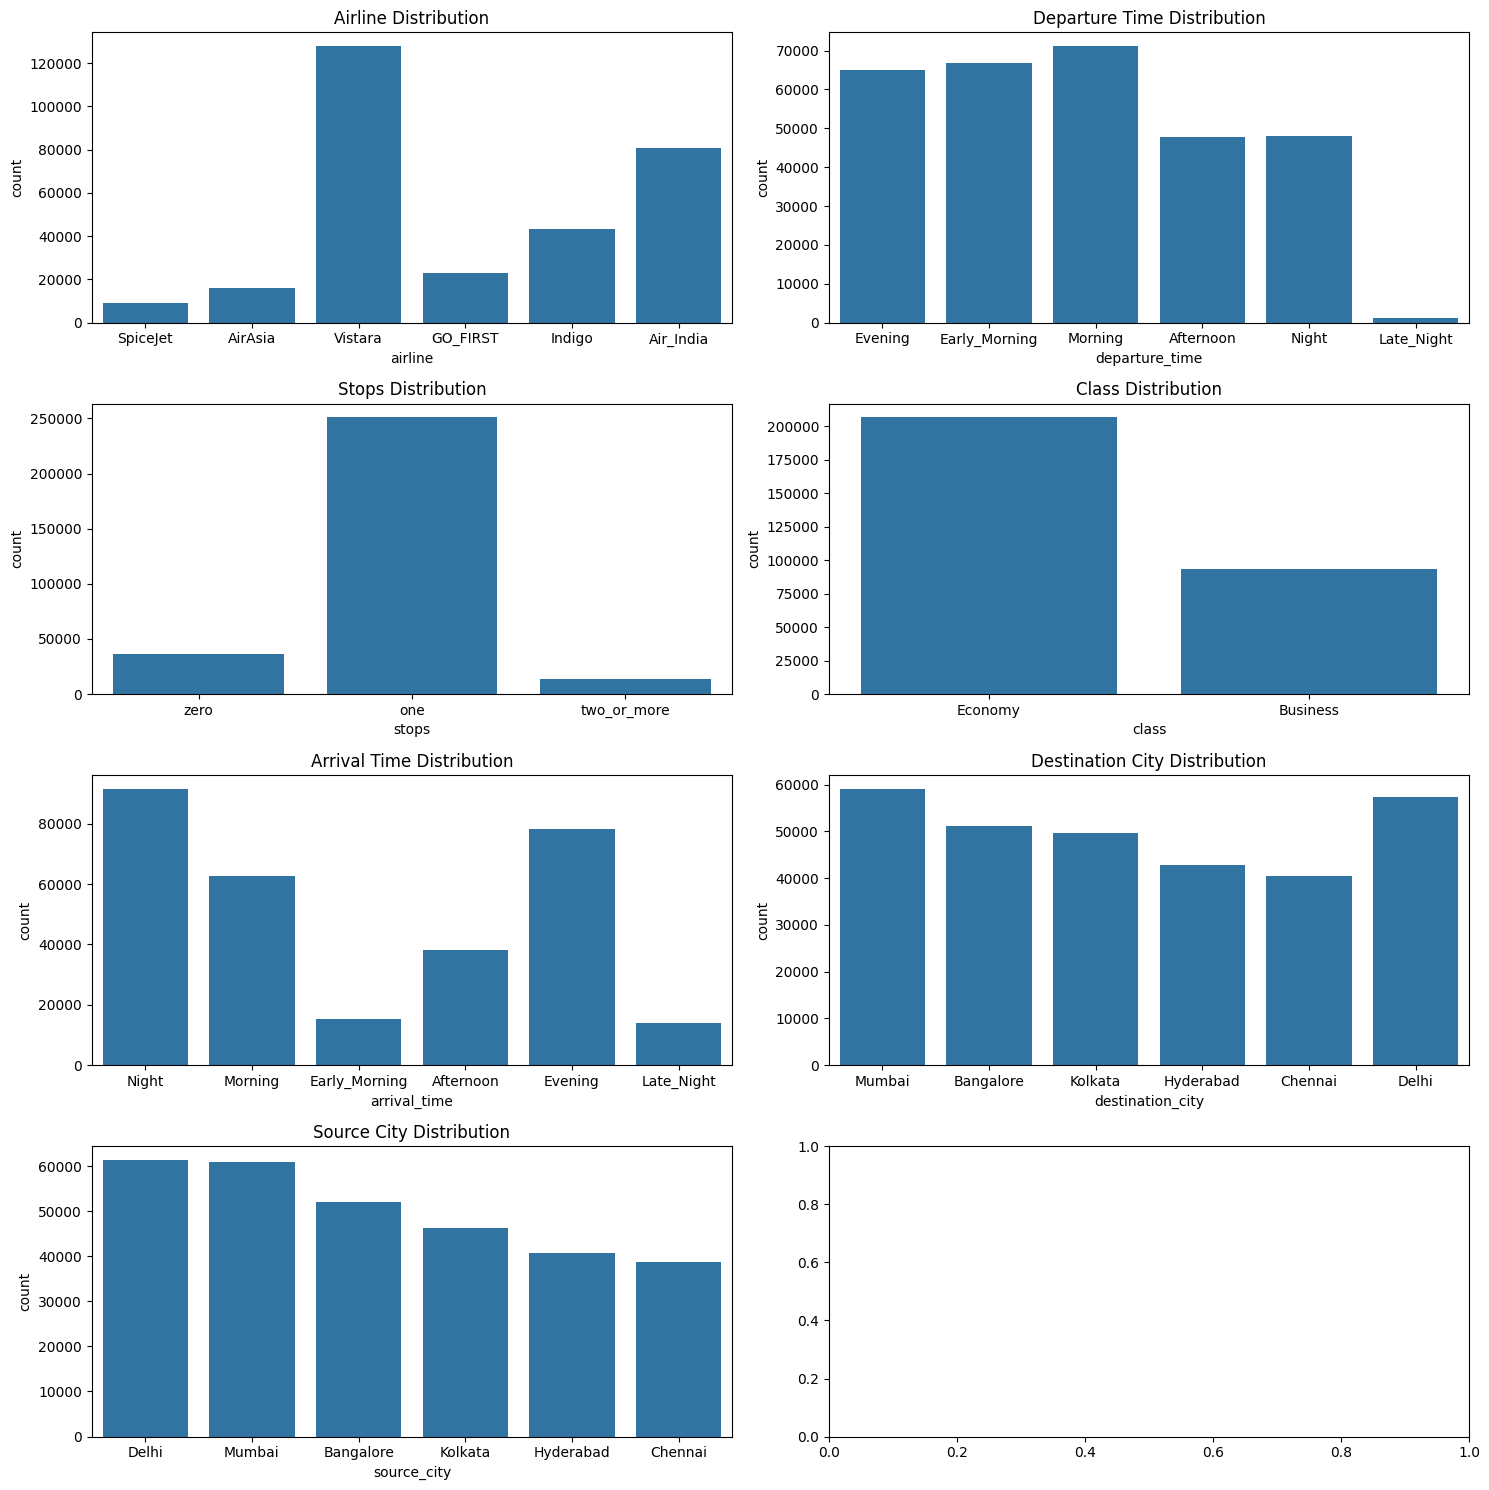

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))


sns.countplot(x='airline', data=dataset, ax=axes[0, 0]).set_title('Airline Distribution')
sns.countplot(x='departure_time', data=dataset, ax=axes[0, 1]).set_title('Departure Time Distribution')
sns.countplot(x='stops', data=dataset, ax=axes[1, 0]).set_title('Stops Distribution')
sns.countplot(x='class', data=dataset, ax=axes[1, 1]).set_title('Class Distribution')
sns.countplot(x='arrival_time', data=dataset, ax=axes[2, 0]).set_title('Arrival Time Distribution')
sns.countplot(x='destination_city', data=dataset, ax=axes[2, 1]).set_title('Destination City Distribution')
sns.countplot(x='source_city', data=dataset, ax=axes[3, 0]).set_title('Source City Distribution')
fig.tight_layout()

Let's move onto numerical data

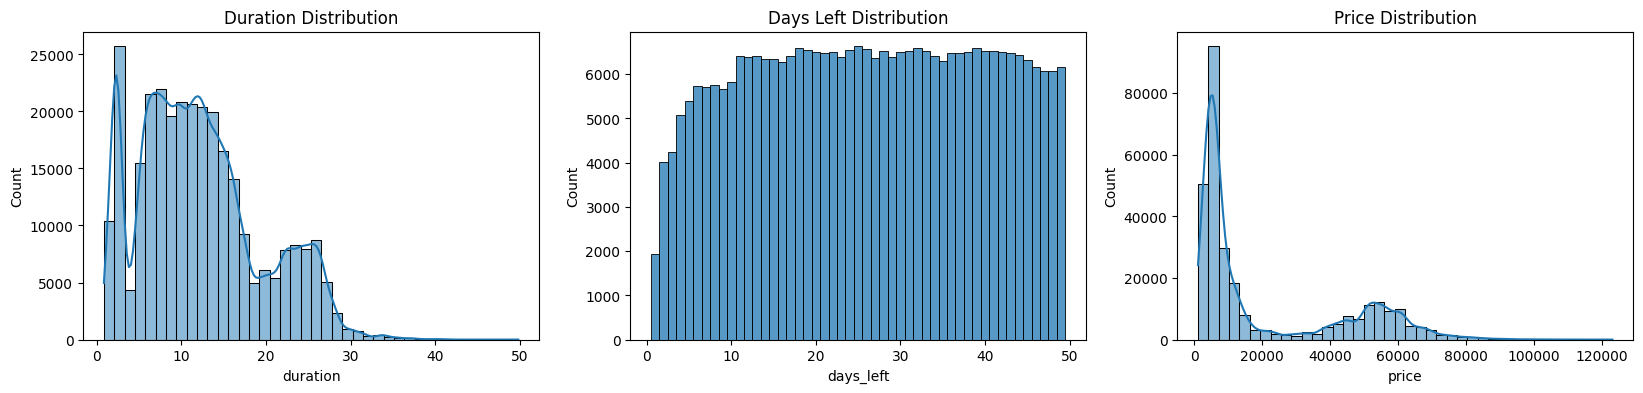

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.660523,22697.767366,1105.00,4783.00,7425.00,42521.00,123071.00


In [9]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

sns.histplot(dataset['duration'], bins=40, kde=True, ax=axes[0]).set_title('Duration Distribution')
sns.histplot(dataset['days_left'], discrete=True, ax=axes[1]).set_title('Days Left Distribution')
sns.histplot(dataset['price'], bins=40, kde=True, ax=axes[2]).set_title('Price Distribution')

plt.show()
dataset.describe().T

Not much surprise when it comes to price distribution - we would excpect that most tickets are relatively cheap, while some of them are much more expensive. The distributions of duration and price are right skewed so it might be good to keep that in mind in future modeling

## Corelation analysis

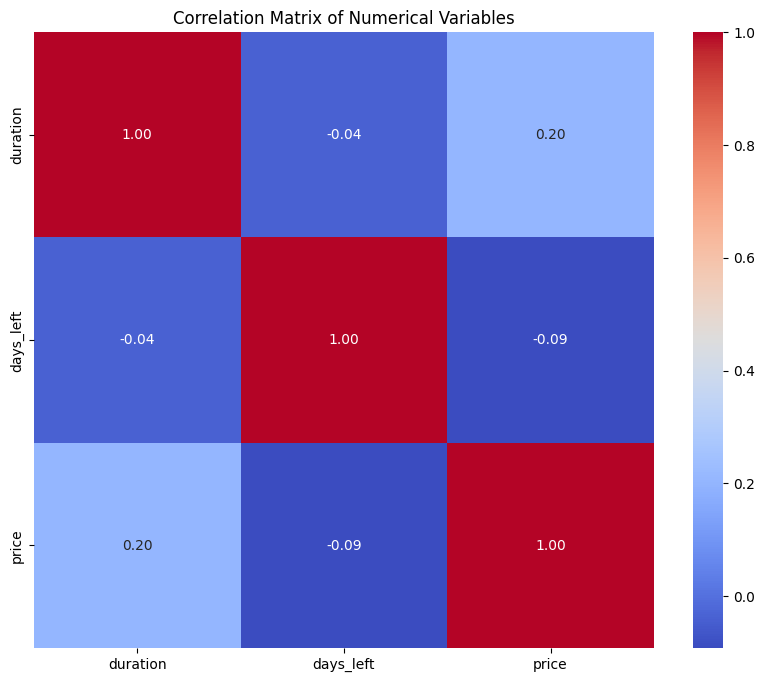

In [10]:

correlation_matrix = dataset[['duration', 'days_left', 'price']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

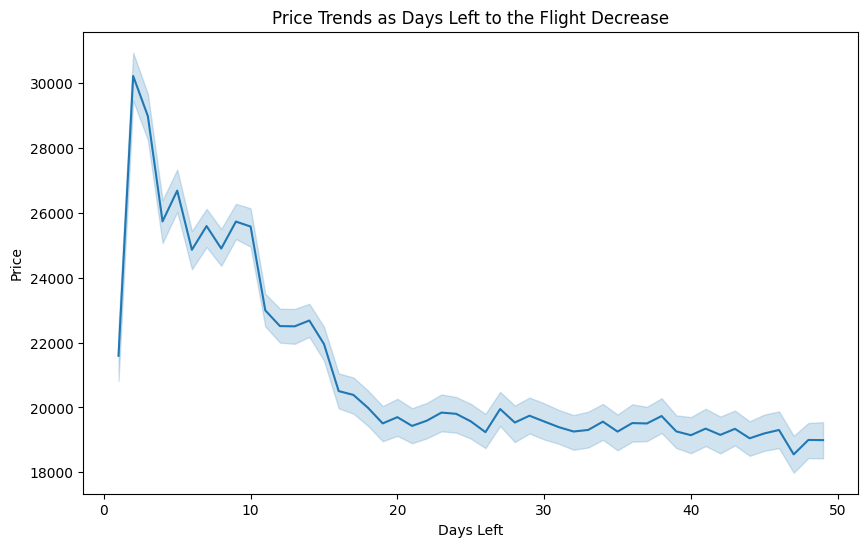

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='days_left', y='price', data=dataset)
plt.title('Price Trends as days left to the flight Decrease')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.show()

Although the correlation matrix shows very weak corelation between price and days left. From above plot we can see that there is clear dependency (when we get close to flight day, there is a big spike in price, as one would expect). This suggest that the relationship between them is non-linear. 

For categorical data, instead of creating correlation matrix, we can take a look at how each category affects mean and median

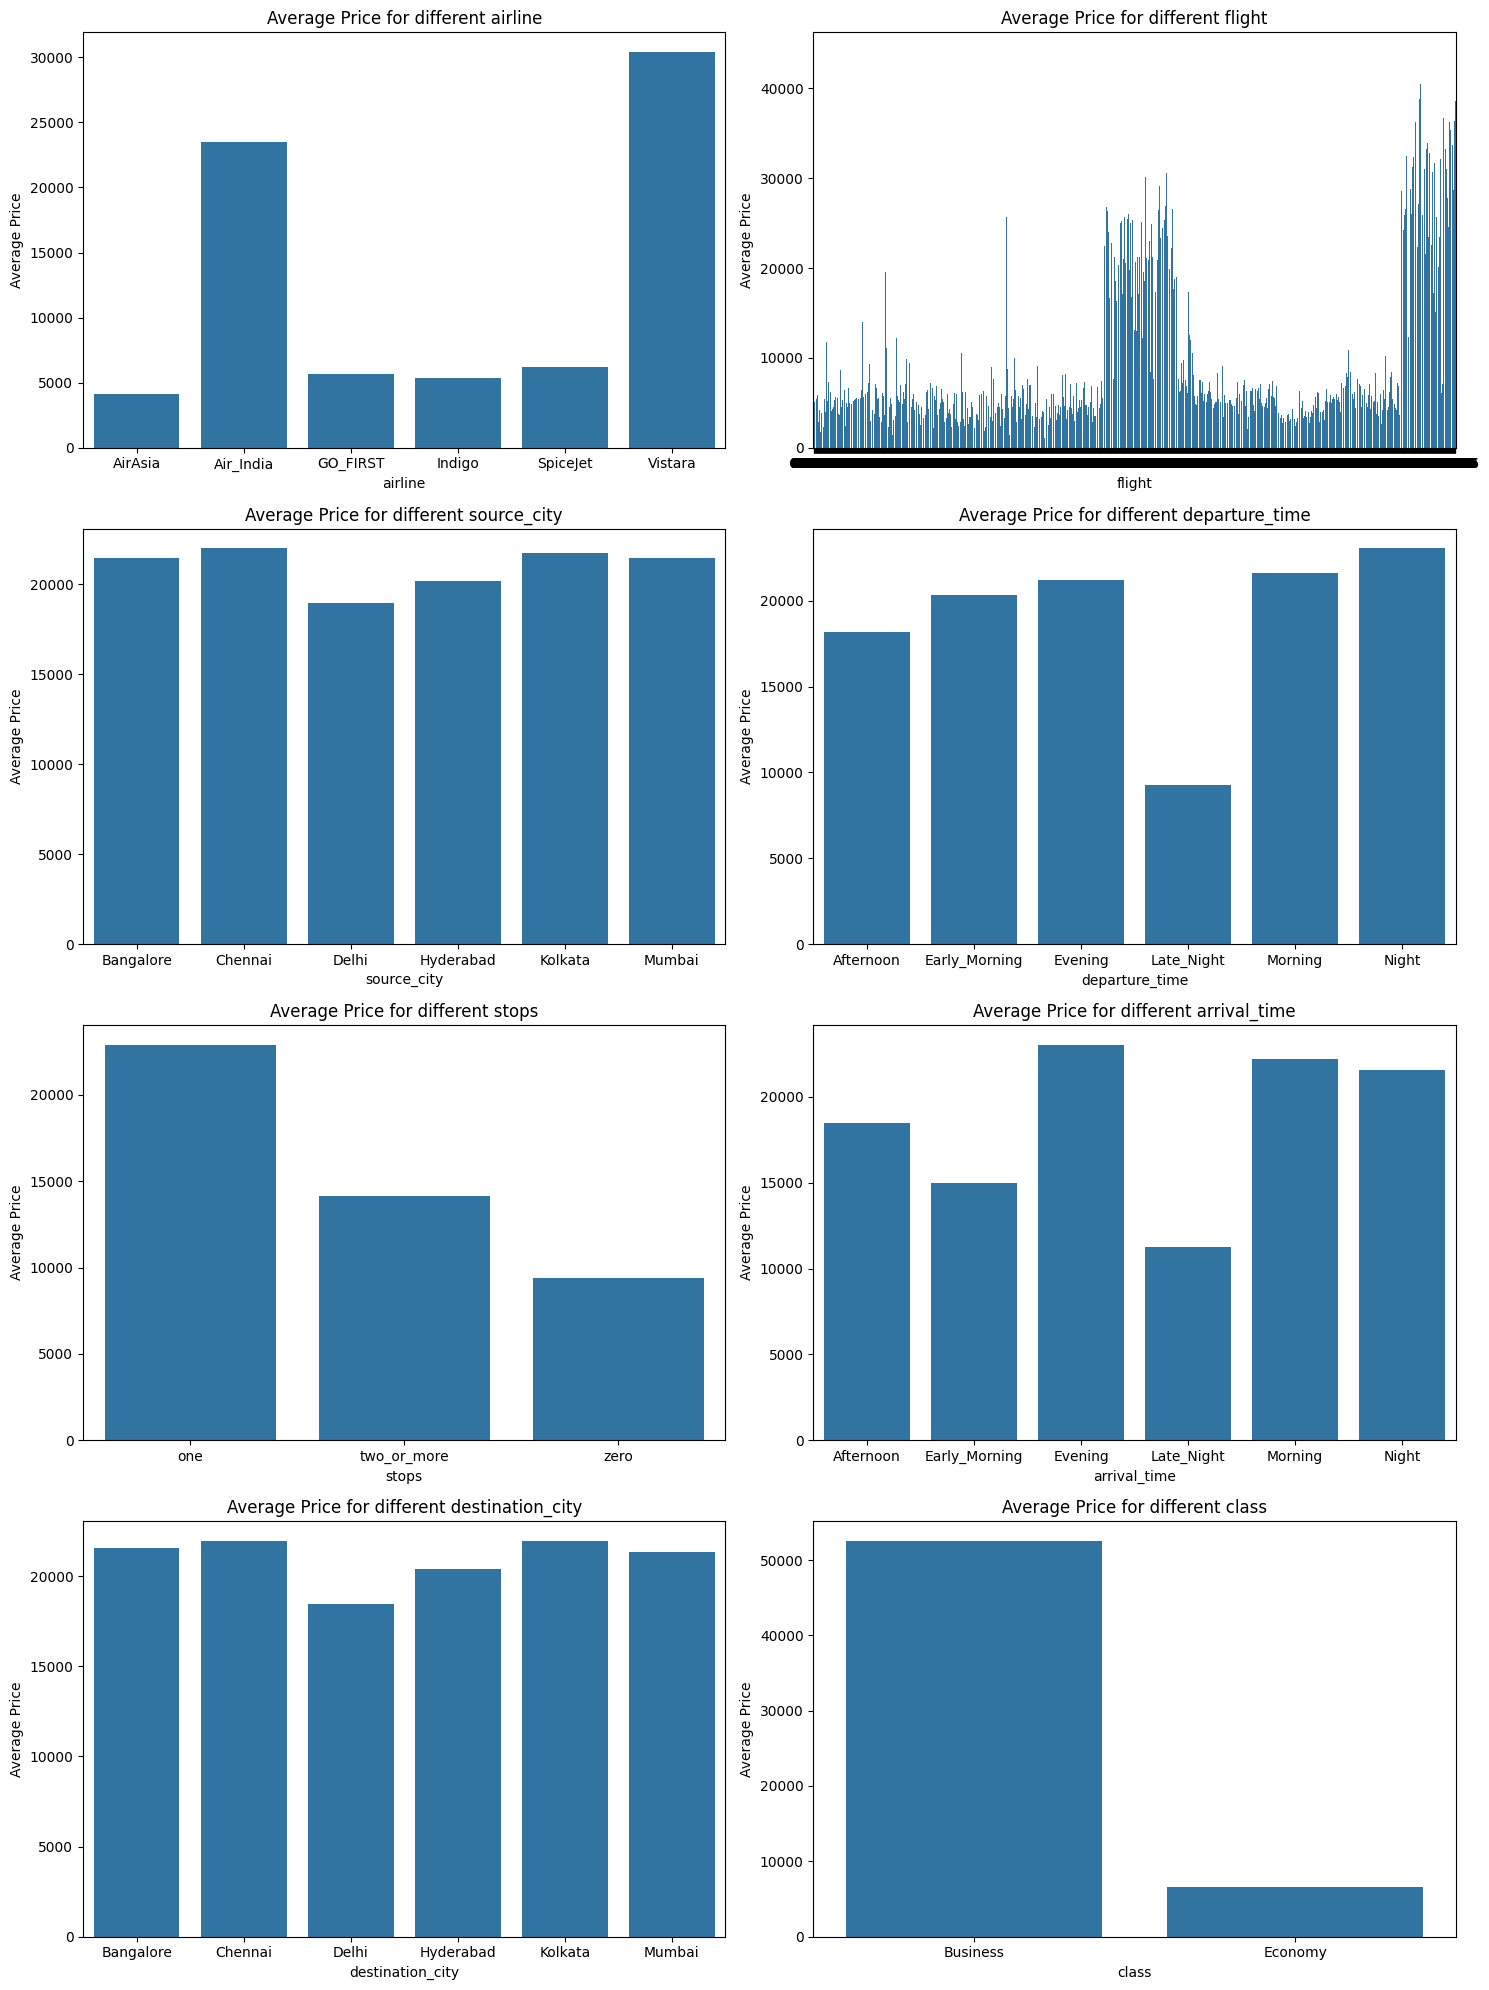

In [37]:
average_price_per_category = {}
for col in categorical_columns:
    average_price_per_category[col] = dataset.groupby(col, observed=True)['price'].mean()


fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten() 

for i, col in enumerate(categorical_columns):
    sns.barplot(x=average_price_per_category[col].index, y=average_price_per_category[col].values, ax=axes[i])
    axes[i].set_title(f'Average Price for different {col}')
    axes[i].set_ylabel('Average Price')
    axes[i].set_xlabel(col)
    

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Looks like the categorical variables will be highly correlated, which makes sense, as 4 of the airlines do not even offer business option. Thus it makes sense, that average price depends greatly on airline, since they are strongly related to class - which as one would expect has very big effect on price. Chi Square is high in all pairs which suggest strong correlation. It might be reasonable to drop 'flight' column, since it has a lot of unique values, and seems like most relevant data is encapsulated in 'class' and 'airline' variables

After this analysis, looks like class, number of stops and duration affect price the most.